# Getting started (Python API)

In this tutorial, you'll install lacuna and run your first analysis using the Python API. 

**What you'll learn**:

- Install lacuna and its dependencies
- Verify your installation is working correctly
- Load mask data with `SubjectData`
- Fetch connectomes programmatically
- Run analyses using the Python API

This tutorial covers the same analyses as [Getting started (CLI)](getting-started-cli.ipynb) but using the Python API. Compared to the command line interface, using the API is a bit more complex. Hence, it takes more space to discuss it thoroughly and in depth functionality is described elsewhere in the documentation. Here we focus on showcase a simple exemplary workflow so you can decide where to go next.


We encourage you to open this notebook in colab and run it interactively. By that you can explore everything and have a more hands-on experience.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m-petersen/lacuna/blob/main/docs/tutorials/getting-started-api.ipynb)

In [1]:
# --- Conda Setup For Colab ---
# Ignore this cell if you run the notebook locally
import os

try:
    import google.colab  # present only in Colab
except Exception:
    print("Not running in Colab — skipping Conda setup")
else:
    if not os.path.exists("/usr/local/conda"):
        !pip install -q condacolab
        import condacolab
        condacolab.install()

Not running in Colab — skipping Conda setup


## Prerequisites

- conda or mamba environment with Python 3.10 or higher
- A coding environment

## Install lacuna and its dependencies

In [2]:
# Install Lacuna from GitHub
#Note: ! enables shell commands in Jupyter
!pip install git+https://github.com/m-petersen/lacuna

# Install MRtrix3 (required for structural network mapping)
!conda install -c conda-forge -c MRtrix3 mrtrix3 libstdcxx-ng

  Cloning https://github.com/m-petersen/lacuna to /tmp/pip-req-build-b7m7utyh
  Running command git clone --filter=blob:none --quiet https://github.com/m-petersen/lacuna /tmp/pip-req-build-b7m7utyh
  Resolved https://github.com/m-petersen/lacuna to commit ab0f6a6213272b09044b6c27a00dc2f751a5c045
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Solving environment: - 
  - mrtrix3/linux-64::mrtrix3-3.0.3-h2bc3f7f_0
  - MRtrix3/linux-64::mrtrix3-3.0.3-h2bc3f7fdone


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [3]:
# Verify installation
import lacuna
print(f"Lacuna version: {lacuna.__version__}")

Lacuna version: 0.0.1.dev328


## The Lacuna Python API

The Python API provides programmatic access to all Lacuna functionality. Key modules include:

| Module | Description |
|--------|-------------|
| `lacuna.SubjectData` | Container for mask data with spatial metadata and results |
| `lacuna.analysis` | Analysis classes: `RegionalDamage`, `FunctionalNetworkMapping`, `StructuralNetworkMapping` |
| `lacuna.io` | Data fetching: `fetch_gsp1000()`, `fetch_dtor985()` |
| `lacuna.data` | Bundled atlases and tutorial data access |
| `lacuna.assets` | Parcellation and connectome registries |

Let's explore the available analyses:

In [4]:
from lacuna.analysis import list_analyses

for name, _ in list_analyses():
    print(f"{name}")

FunctionalNetworkMapping
ParcelAggregation
RegionalDamage
StructuralNetworkMapping


## Get the tutorial data

Lacuna bundles a synthetic BIDS dataset for tutorials. Access it via `lacuna.data`:

- **`get_tutorial_subjects()`** – List subject IDs
- **`setup_tutorial_data(path)`** – Copy to a working directory

Lacuna handles coordinate space transformations automatically using [TemplateFlow](https://www.templateflow.org/). Supported spaces: `MNI152NLin6Asym` and `MNI152NLin2009cAsym`.

In [5]:
from lacuna.data import get_tutorial_subjects, setup_tutorial_data

# Setup tutorial data in a working directory
tutorial_dir = setup_tutorial_data("/tmp/tutorial_data", overwrite=True)
print(f"Working copy at: {tutorial_dir}")

# List available subjects
subjects = get_tutorial_subjects()
print(f"\nSubjects: {subjects}")

Working copy at: /tmp/tutorial_data

Subjects: ['sub-01', 'sub-02', 'sub-03']


## Load mask data with SubjectData

`SubjectData` is the central container for mask-based analysis. It holds the binary mask image, spatial metadata, and analysis results.

In [6]:
from lacuna import SubjectData

# Load a lesion mask
lesion_path = tutorial_dir / "sub-01/ses-01/anat/sub-01_ses-01_space-MNI152NLin6Asym_label-acuteinfarct_mask.nii.gz"

# Create SubjectData - space and resolution are auto-detected from the filename/header
mask_data = SubjectData.from_nifti(
    lesion_path,
    space="MNI152NLin6Asym",  # Can be auto-detected but explicit is clearer
    resolution=1.0
)

print(f"Subject ID: {mask_data.metadata['subject_id']}")
print(f"Space: {mask_data.space}")
print(f"Resolution: {mask_data.resolution} mm")
print(f"Volume: {mask_data.get_volume_mm3():.2f} mm³")

Subject ID: sub-01
Space: MNI152NLin6Asym
Resolution: 1.0 mm
Volume: 14147.00 mm³


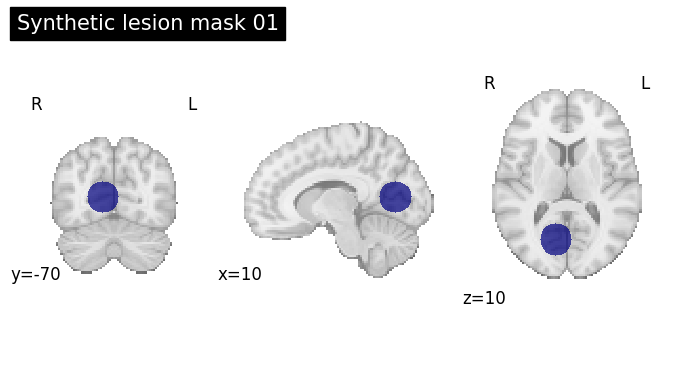

In [7]:
# Visualize the lesion mask
from nilearn import plotting

plotting.plot_roi(
    mask_data.mask_img,
    radiological=True,
    title="Synthetic lesion mask 01",
    draw_cross=False,
    colorbar=False
)

## Regional damage analysis

The first analysis quantifies the overlap of the lesion mask with a parcellation atlas. Lacuna provides direct access to the Schaefer cortical and Tian (Melbourne) subcortical atlases in different resolutions, plus the HCP1065 white matter tract atlas.

You can check the available atlases:

In [8]:
from lacuna.assets.parcellations import list_parcellations

# List all available atlases
for parcellation in list_parcellations():
    print(f"{parcellation.name}, space={parcellation.space}")

HCP1065_thr0p1, space=MNI152NLin2009aAsym
Schaefer2018TianS1_400Parcels17Networks, space=MNI152NLin6Asym
Schaefer2018TianS2_400Parcels17Networks, space=MNI152NLin6Asym
Schaefer2018TianS3_400Parcels17Networks, space=MNI152NLin6Asym
Schaefer2018_1000Parcels17Networks, space=MNI152NLin6Asym
Schaefer2018_1000Parcels7Networks, space=MNI152NLin6Asym
Schaefer2018_100Parcels17Networks, space=MNI152NLin6Asym
Schaefer2018_100Parcels7Networks, space=MNI152NLin6Asym
Schaefer2018_200Parcels17Networks, space=MNI152NLin6Asym
Schaefer2018_200Parcels7Networks, space=MNI152NLin6Asym
Schaefer2018_400Parcels17Networks, space=MNI152NLin6Asym
Schaefer2018_400Parcels7Networks, space=MNI152NLin6Asym
TianSubcortex_3TS1, space=MNI152NLin6Asym
TianSubcortex_3TS2, space=MNI152NLin6Asym
TianSubcortex_3TS3, space=MNI152NLin6Asym


Now let's run the regional damage analysis using `RegionalDamage`:

In [9]:
from lacuna.analysis import RegionalDamage

rd_analysis = RegionalDamage(
    parcel_names=["Schaefer2018_100Parcels7Networks"],
    verbose=True
)

# Run the analysis
processed_rd = rd_analysis.run(mask_data)

In [11]:
import pandas as pd

# Results are stored in the 'RegionalDamage' namespace within nested dictionaries
# You can access them directly like this:
_ = processed_rd.results["RegionalDamage"]["atlas-Schaefer2018_100Parcels7Networks_source-InputMask"].get_data()

# But it's easier to use the get_result() method which also allows pattern matching:
parcel_dict = processed_rd.get_result("RegionalDamage", pattern="*Schaefer*")

df = pd.DataFrame(parcel_dict.values(), index=parcel_dict.keys(), columns=["value"])
df.sort_values(by="value", ascending=False, inplace=False)

,value
7Networks_RH_Vis_5,63.361935
7Networks_RH_Vis_6,28.837823
7Networks_RH_Default_pCunPCC_1,15.208071
7Networks_LH_Vis_6,11.231361
7Networks_RH_Vis_8,4.003756
...,...
7Networks_RH_Default_PFCv_1,0.000000
7Networks_RH_Default_PFCdPFCm_1,0.000000
7Networks_RH_Default_PFCv_2,0.000000
7Networks_RH_Default_PFCdPFCm_3,0.000000


## Process multiple subjects

The API makes it easy to process multiple subjects efficiently via the `batch_process` function.

In [ ]:
# Find all lesion masks in the tutorial dataset
mask_paths = list(tutorial_dir.rglob("*_mask.nii.gz"))

# Build SubjectData objects
subjects = [SubjectData.from_nifti(p, space="MNI152NLin6Asym", resolution=1.0) for p in mask_paths]


In [ ]:
from lacuna.batch.api import batch_process
from lacuna.batch.extract import extract
import pandas as pd

# Run the RegionalDamage analysis over all subjects using a notebook-friendly backend
batch_results = batch_process(
    inputs=subjects,
    analysis=rd_analysis,
    n_jobs=2,                # use more cores if available; use 1 for sequential
    backend="threading",
    show_progress=True,
)

RegionalDamage: 100%|██████████| 3/3 [00:05<00:00,  1.96s/mask]


For batch processing the `extract` function helps to unpack nested data from processing results

In [ ]:

parcel_dicts = extract(batch_results=batch_results, analysis="RegionalDamage", 
                     pattern="*Schaefer*", unwrap=True)

parcel_dict = parcel_dicts["sub-01_ses-01"]

df = pd.DataFrame.from_dict(parcel_dict, orient="index", columns=["value"])

df.sort_values(by="value", ascending=False, inplace=False)

,value
7Networks_RH_Vis_5,63.361935
7Networks_RH_Vis_6,28.837823
7Networks_RH_Default_pCunPCC_1,15.208071
7Networks_LH_Vis_6,11.231361
7Networks_RH_Vis_8,4.003756
...,...
7Networks_RH_Default_PFCv_1,0.000000
7Networks_RH_Default_PFCdPFCm_1,0.000000
7Networks_RH_Default_PFCv_2,0.000000
7Networks_RH_Default_PFCdPFCm_3,0.000000


## Structural Lesion Network Mapping

Structural lesion network mapping identifies the white matter fiber bundles connected to a lesion. It requires a normative tractogram (structural connectome).

## Fetch the dTOR985 tractogram

Use `fetch_dtor985()` to download the tractogram from Figshare. You need an API key from [figshare.com](https://figshare.com/) which you can obtain after registration (Account → Integrations → Personal Tokens).

In [5]:
from lacuna.io import fetch_dtor985

YOUR_FIGSHARE_API_KEY = "6c0aa307c3f59f7fca89e3ed75ec598812df83e073c57ebc8e339962ed54f8303941c0c213fea609369c36bfafff5a9a73b40c47ce6da4a75caaaca358360bda"  # Replace with your token

result = fetch_dtor985(
    output_dir="/tmp/dtor985_data",
    api_key=YOUR_FIGSHARE_API_KEY,
    verbose=True
)

Using existing .tck file: /tmp/dtor985_data/dTOR_full_tractogram.tck


In [7]:
result

FetchResult(success=True, connectome_name='dtor985', output_dir=PosixPath('/tmp/dtor985_data'), output_files=[PosixPath('/tmp/dtor985_data/dTOR_full_tractogram.trk'), PosixPath('/tmp/dtor985_data/dTOR_full_tractogram.tck')], registered=False, register_name=None, duration_seconds=0.17618775367736816, download_time_seconds=0.17590618133544922, processing_time_seconds=0.0001609325408935547, warnings=['Using existing .tck file: /tmp/dtor985_data/dTOR_full_tractogram.tck', "Registration failed: register_structural_connectome() got an unexpected keyword argument 'n_subjects'"], error=None)

This automatically adds the connectome to the registry so lacuna can see and use it.

In [14]:
from lacuna.assets.connectomes import list_structural_connectomes

list_structural_connectomes()

[]

## Run structural network mapping

The analysis internally:
1. Ensures space alignment
2. Computes the voxel-level tract density image (TDI) of the full tractogram
3. Filters the normative tractogram by the lesion mask
4. Computes the TDI of the lesion-filtered tractogram and divides by the original TDI to obtain a disconnection map

In [42]:
result

FetchResult(success=True, connectome_name='dtor985', output_dir=PosixPath('/tmp/dtor985_data'), output_files=[PosixPath('/tmp/dtor985_data/dTOR_full_tractogram.trk'), PosixPath('/tmp/dtor985_data/dTOR_full_tractogram.tck')], registered=False, register_name=None, duration_seconds=2819.292998790741, download_time_seconds=2620.477270126343, processing_time_seconds=198.81564736366272, warnings=["Registration failed: register_structural_connectome() got an unexpected keyword argument 'n_subjects'"], error=None)

In [ ]:
from lacuna.analysis import StructuralNetworkMapping

# Initialize with the registered connectome
snm_analysis = StructuralNetworkMapping(
    connectome_name="dTOR985",  # Uses registered name from fetch_dtor985()
    verbose=True
)

# Run on a single subject
snm_result = snm_analysis.run(mask_data)

print(f"\nResults: {list(snm_result.results['StructuralNetworkMapping'].keys())}")

In [ ]:
# Visualize the disconnection map
disconnection_map = snm_result.results["StructuralNetworkMapping"]["disconnectionmap"]

plotting.plot_stat_map(
    disconnection_map.data,  # VoxelMap contains .data attribute with NIfTI
    radiological=True,
    title="Disconnection map from SNM\n(% of streamlines connecting to the lesion)",
    draw_cross=False,
    colorbar=True,
    dim=-0.2,
    cmap='Reds'
)

# Functional Lesion Network Mapping

Functional Lesion Network Mapping maps the functional brain circuitry connecting to the lesion using a normative functional connectome (resting-state fMRI data).

## Fetch the GSP1000 connectome

Use `fetch_gsp1000()` to download from Harvard Dataverse. Get an API key from [Harvard Dataverse](https://dataverse.harvard.edu/) (click username → API Token).

In [ ]:
from lacuna.io import fetch_gsp1000

YOUR_DATAVERSE_API_KEY = "YOUR_TOKEN_HERE"  # Replace with your token

result = fetch_gsp1000(
    output_dir="/tmp/gsp1000_data",
    api_key=YOUR_DATAVERSE_API_KEY,
    test_mode=True,  # Only download a small test subset
    skip_checksum=True,
    verbose=True
)

print(f"\nDownload successful: {result.success}")
print(f"Registered as: {result.register_name}")

## Run functional network mapping

The analysis:
1. Ensures space alignment and resamples mask to connectome space
2. Loads timeseries (subjects × timepoints × voxels)
3. Extracts lesion timeseries using BOES (mean) or PINI (PCA-based) method
4. Computes voxel-wise Pearson correlations, Fisher z-transform, and t-statistics
5. Optionally computes p-value maps and FDR-corrected significance maps

In [ ]:
from lacuna.analysis import FunctionalNetworkMapping

# Initialize with registered connectome and options
fnm_analysis = FunctionalNetworkMapping(
    connectome_name="GSP1000",  # Uses registered name from fetch_gsp1000()
    method="boes",              # or "pini" for PCA-based extraction
    compute_p_map=True,
    fdr_alpha=0.05,
    verbose=True
)

# Run on a single subject
fnm_result = fnm_analysis.run(mask_data)

print(f"\nResults: {list(fnm_result.results['FunctionalNetworkMapping'].keys())}")

In [ ]:
# Visualize the t-statistic map
tmap = fnm_result.results["FunctionalNetworkMapping"]["tmap"]

plotting.plot_stat_map(
    tmap.data,
    radiological=True,
    title="T-statistic map from FNM",
    draw_cross=False,
    colorbar=True,
    cmap='seismic',
    vmin=-5,
    vmax=5
)

The map looks a bit speckled but this is expected due to only a small fraction of connectome subjects being considered in this test run. Once the full connectome is used the map will be smoother.

## Access summary statistics

In [ ]:
# Get summary statistics from the analysis
summary = fnm_result.results["FunctionalNetworkMapping"]["summarystatistics"]

print("FNM Summary Statistics:")
for key, value in summary.data.items():
    print(f"  {key}: {value}")

## Save all results

Save the network mapping results to disk:

In [ ]:
output_dir_snm = Path("/tmp/outputs_snm_api")
output_dir_fnm = Path("/tmp/outputs_fnm_api")

snm_result.save_results(output_dir_snm)
fnm_result.save_results(output_dir_fnm)

print("SNM outputs:")
for p in sorted(output_dir_snm.rglob("*")):
    if p.is_file():
        print(f"  {p.relative_to(output_dir_snm)}")

print("\nFNM outputs:")
for p in sorted(output_dir_fnm.rglob("*")):
    if p.is_file():
        print(f"  {p.relative_to(output_dir_fnm)}")

# Advanced: Custom connectome registration

If you have your own connectome data, you can register it manually:

In [ ]:
from lacuna.assets.connectomes import (
    register_functional_connectome,
    register_structural_connectome,
    list_functional_connectomes,
    list_structural_connectomes,
)

# Example: Register a custom functional connectome
# register_functional_connectome(
#     name="MyConnectome",
#     space="MNI152NLin6Asym",
#     resolution=2.0,
#     data_path="/path/to/my_connectome.h5",  # or directory for batched
#     n_subjects=500,
#     description="My custom connectome"
# )

# List registered connectomes
print("Registered functional connectomes:")
for conn in list_functional_connectomes():
    print(f"  {conn.name}: {conn.metadata.space}, {conn.metadata.n_subjects} subjects")

print("\nRegistered structural connectomes:")
for conn in list_structural_connectomes():
    print(f"  {conn.name}: {conn.metadata.space}")

This concludes the Python API tutorial. For more advanced usage, see the other tutorials and the API reference documentation.